# Importar librerías necesarias

In [1]:
# Importar librerías
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
import statsmodels.api as sm
import seaborn as sns
import xgboost as xgb
import holidays
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Cargar datos y revisión general

In [2]:
# Cargar el archivo CSV
df = pd.read_csv("database.csv", sep=",")
pd.set_option('display.max_columns', None)

# Observar las primeras filas de cada columna
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
# Verificación de estructura del dataframe
print(df.shape) # Muestra las dimensiones en filas y columnas
print(df.info())  # Muestra el tipo de datos y valores nulos
print(df.describe())  # Muestra estadísticas básicas

(48895, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review         

In [4]:
# Vamos a identificar si existen valores constantes en alguna de estas columnas
n_unicos = df.nunique()
n_unicos

id                                48895
name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

No existen columnas que contengan valores constantes

In [5]:
# Comprobar la presencia de filas duplicadas
df.duplicated().sum()

np.int64(0)

No existen duplicados entre los valores registrados en nuestro DataFrame

In [6]:
# Eliminar las columnas que no son necesarias y modificar el df directamente
df.drop(columns=['id', 'name', 'host_id', 'host_name', 'last_review', 'calculated_host_listings_count'], inplace=True)
print(df.shape)

(48895, 10)


# Distribución de las variables y relación entre variables

In [7]:
# Cálculo de las estadísticas básicas de las columnas del df
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
neighbourhood_group,48895,5,Manhattan,21661,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighbourhood,48895,221,Williamsburg,3920,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,48895.0,NaN,NaN,NaN,40.728949,0.05453,40.49979,40.6901,40.72307,40.763115,40.91306
longitude,48895.0,NaN,NaN,NaN,-73.95217,0.046157,-74.24442,-73.98307,-73.95568,-73.936275,-73.71299
room_type,48895,3,Entire home/apt,25409,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,48895.0,NaN,NaN,NaN,152.720687,240.15417,0.0,69.0,106.0,175.0,10000.0
minimum_nights,48895.0,NaN,NaN,NaN,7.029962,20.51055,1.0,1.0,3.0,5.0,1250.0
number_of_reviews,48895.0,NaN,NaN,NaN,23.274466,44.550582,0.0,1.0,5.0,24.0,629.0
reviews_per_month,38843.0,NaN,NaN,NaN,1.373221,1.680442,0.01,0.19,0.72,2.02,58.5
availability_365,48895.0,NaN,NaN,NaN,112.781327,131.622289,0.0,0.0,45.0,227.0,365.0


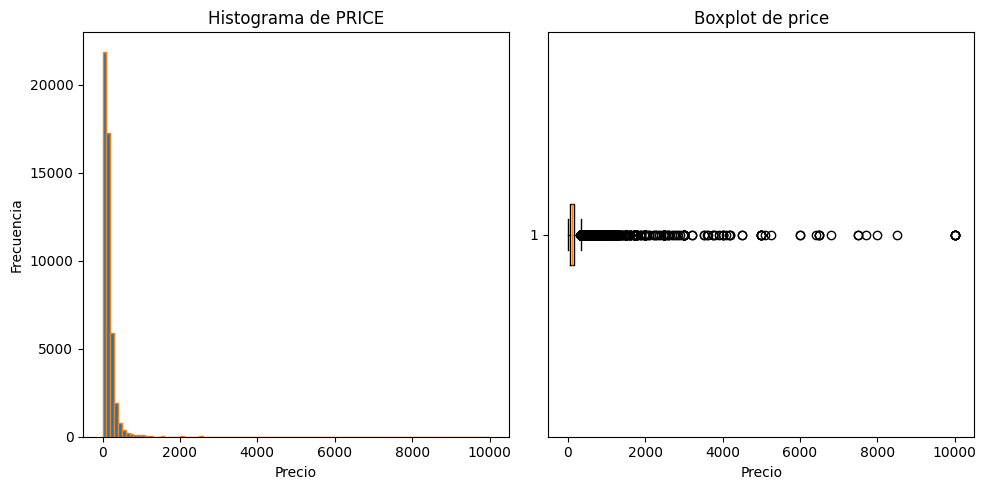

In [8]:
# Crear una figura con dos subplots (uno para el histograma y otro para el boxplot)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Crear un histograma en el primer subplot
ax[0].hist(df['price'], bins=100, color='#1f77b4', edgecolor='#ff7f0e')
ax[0].set_title('Histograma de PRICE')
ax[0].set_xlabel('Precio')
ax[0].set_ylabel('Frecuencia')

# Crear un boxplot en el segundo subplot
ax[1].boxplot(df['price'], vert=False)
ax[1].set_title('Boxplot de price')
ax[1].set_xlabel('Precio')

# Mostrar la figura
plt.tight_layout()
plt.show()

El histograma muestra una concentración en el expremo izquierdo del gráfico con (precios inferiores a 1000). La presencia de valores extremos localizados en la parte derecha de este gráfico podría afectar a los modelos de regresión y análisis estadístico. Por este motivo, usaremos a continuación la normalización de datos con el objetivo de mejorar la interpretación de los mismos y reducir el ruido generado por los valores extremos.

Así, creamos la columna log_price, que representa el precio transformado con una función logarítmica. Lo que permite reducir la influencia de valores extremos.

In [9]:
# Identificar los casos en los que se registra 0 en el precio
#Creamos la columna log_price
df.loc[:, 'log_price'] = np.log(df['price'] + 1)  # Evita problemas con log(0)

df = df[df['price'] > 0]  # Filtra valores cero antes de calcular el log
df.loc[:, 'log_price'] = np.log(df['price'])

print(df['price'].describe())  # Revisa mínimos y posibles valores incorrectos

df['log_price'] = np.where(df['price'] > 0, np.log(df['price']), 0)

count    48884.000000
mean       152.755053
std        240.170260
min         10.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64


Text(0.5, 0, 'Precio')

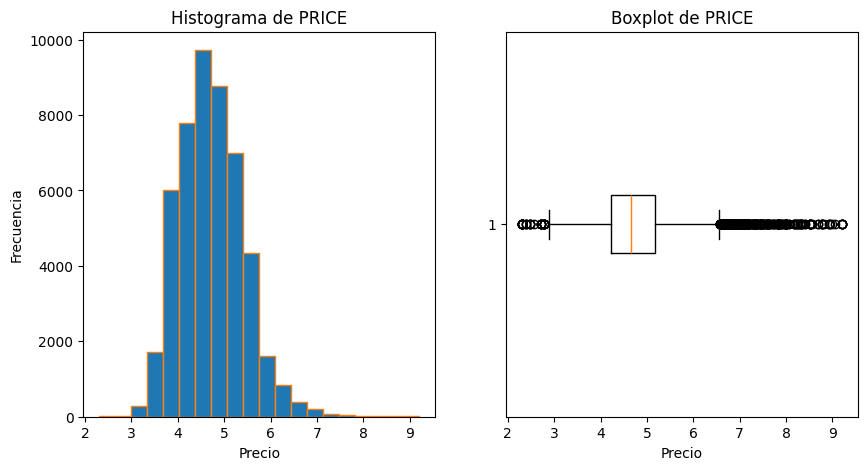

In [10]:
# Crear una figura con dos subplots (uno para el histograma y otro para el boxplot)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Crear un histograma en el primer subplot
ax[0].hist(df['log_price'], bins=20, color='#1f77b4', edgecolor='#ff7f0e')
ax[0].set_title('Histograma de PRICE')
ax[0].set_xlabel('Precio')
ax[0].set_ylabel('Frecuencia')

# Crear un boxplot en el segundo subplot
ax[1].boxplot(df['log_price'], vert=False)
ax[1].set_title('Boxplot de PRICE')
ax[1].set_xlabel('Precio')

El histograma muestra la concentración de precios en la mitad izquierda del gráfico. Por lo tanto, existe un sesgo a la derecha y, por lo tanto, se puede concluir que existen algunos precios de alojamientos excepcionalmente altos.
Por su parte, el Bloxpot muestravalores atípicos localizados fuera de los bigotes. Lo que representa la presencia de precios significativamente más altos que la mayoría.

Existen variables categóricas en este dataset. USaremos One-Hot Encoding para crear una nueva columna con valores 0 o 1, asignando 1 si la fila pertenece a la categoría y 0 en caso contrario..
Son tres las variables a considerar: neighbourhood_group, neighbourhood, room_type

In [11]:
# Mostrar los datos de las variables categóricas
pd.set_option('display.max_columns', None)
df[['neighbourhood_group', 'neighbourhood', 'room_type']].head()

,neighbourhood_group,neighbourhood,room_type
0,Brooklyn,Kensington,Private room
1,Manhattan,Midtown,Entire home/apt
2,Manhattan,Harlem,Private room
3,Brooklyn,Clinton Hill,Entire home/apt
4,Manhattan,East Harlem,Entire home/apt


In [12]:
df_encoded = pd.get_dummies(df, columns=['neighbourhood_group', 'neighbourhood', 'room_type'])

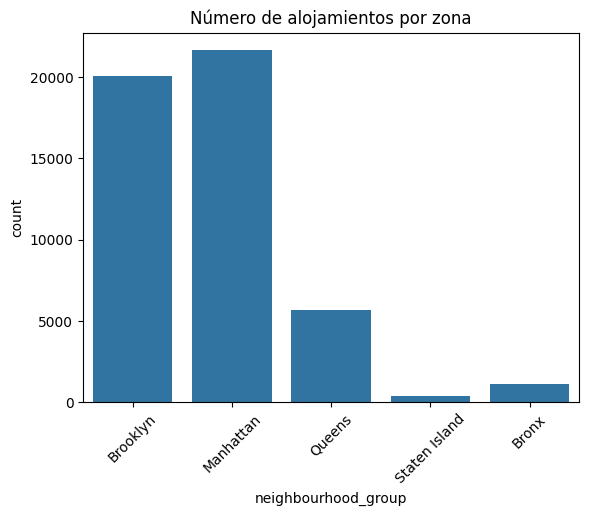

In [13]:
sns.countplot(x='neighbourhood_group', data=df)
plt.title('Número de alojamientos por zona')
plt.xticks(rotation=45)
plt.show()

El gráfico muestra la concentración de alojamientos en Brooklyn y Manhattan. Los sigue Queens aunque en otra escala.

# Valores faltantes e imputación

In [14]:
# Ver porcentaje de valores faltantes por columna
missing_values = df.isnull().sum() / len(df) * 100
print(missing_values)

# Ver porcentaje de filas con valores faltantes
missing_rows = df.isnull().sum(axis=1)
print(f"Porcentaje de filas con al menos un valor faltante: {missing_rows.value_counts(normalize=True)*100}") # devuelve la frecuencia relativa de cada número de valores nulos

neighbourhood_group     0.00000
neighbourhood           0.00000
latitude                0.00000
longitude               0.00000
room_type               0.00000
price                   0.00000
minimum_nights          0.00000
number_of_reviews       0.00000
reviews_per_month      20.56092
availability_365        0.00000
log_price               0.00000
dtype: float64
Porcentaje de filas con al menos un valor faltante: 0    79.43908
1    20.56092
Name: proportion, dtype: float64


El resultado muestra que todas las columnas tienen 0% de valores faltantes, pero al mismo tiempo el análisis de filas indica que el 100% de las filas tienen al menos un valor faltante.
El problema es que missing_rows.value_counts(normalize=True)*100 devuelve la frecuencia relativa de cada número de valores nulos, pero no está filtrando específicamente las filas con valores faltantes.

In [15]:
missing_rows_percentage = (missing_rows > 0).mean() * 100 # missing_rows > 0 crea un booleano donde True significa que la fila tiene al menos un valor nulo. Luego .mean() calcula el porcentaje de esas filas.
print(f"Porcentaje de filas con al menos un valor faltante: {missing_rows_percentage:.2f}%") 

Porcentaje de filas con al menos un valor faltante: 20.56%


In [16]:
# Calculamos el porcentaje de lineas que tienen al menos un valor nulo
df.isnull().any(axis=1).sum()/len(df)*100

np.float64(20.56091972833647)

Podemos usar missingno para ver si hay patrones claros en la distribución de los valores faltantes

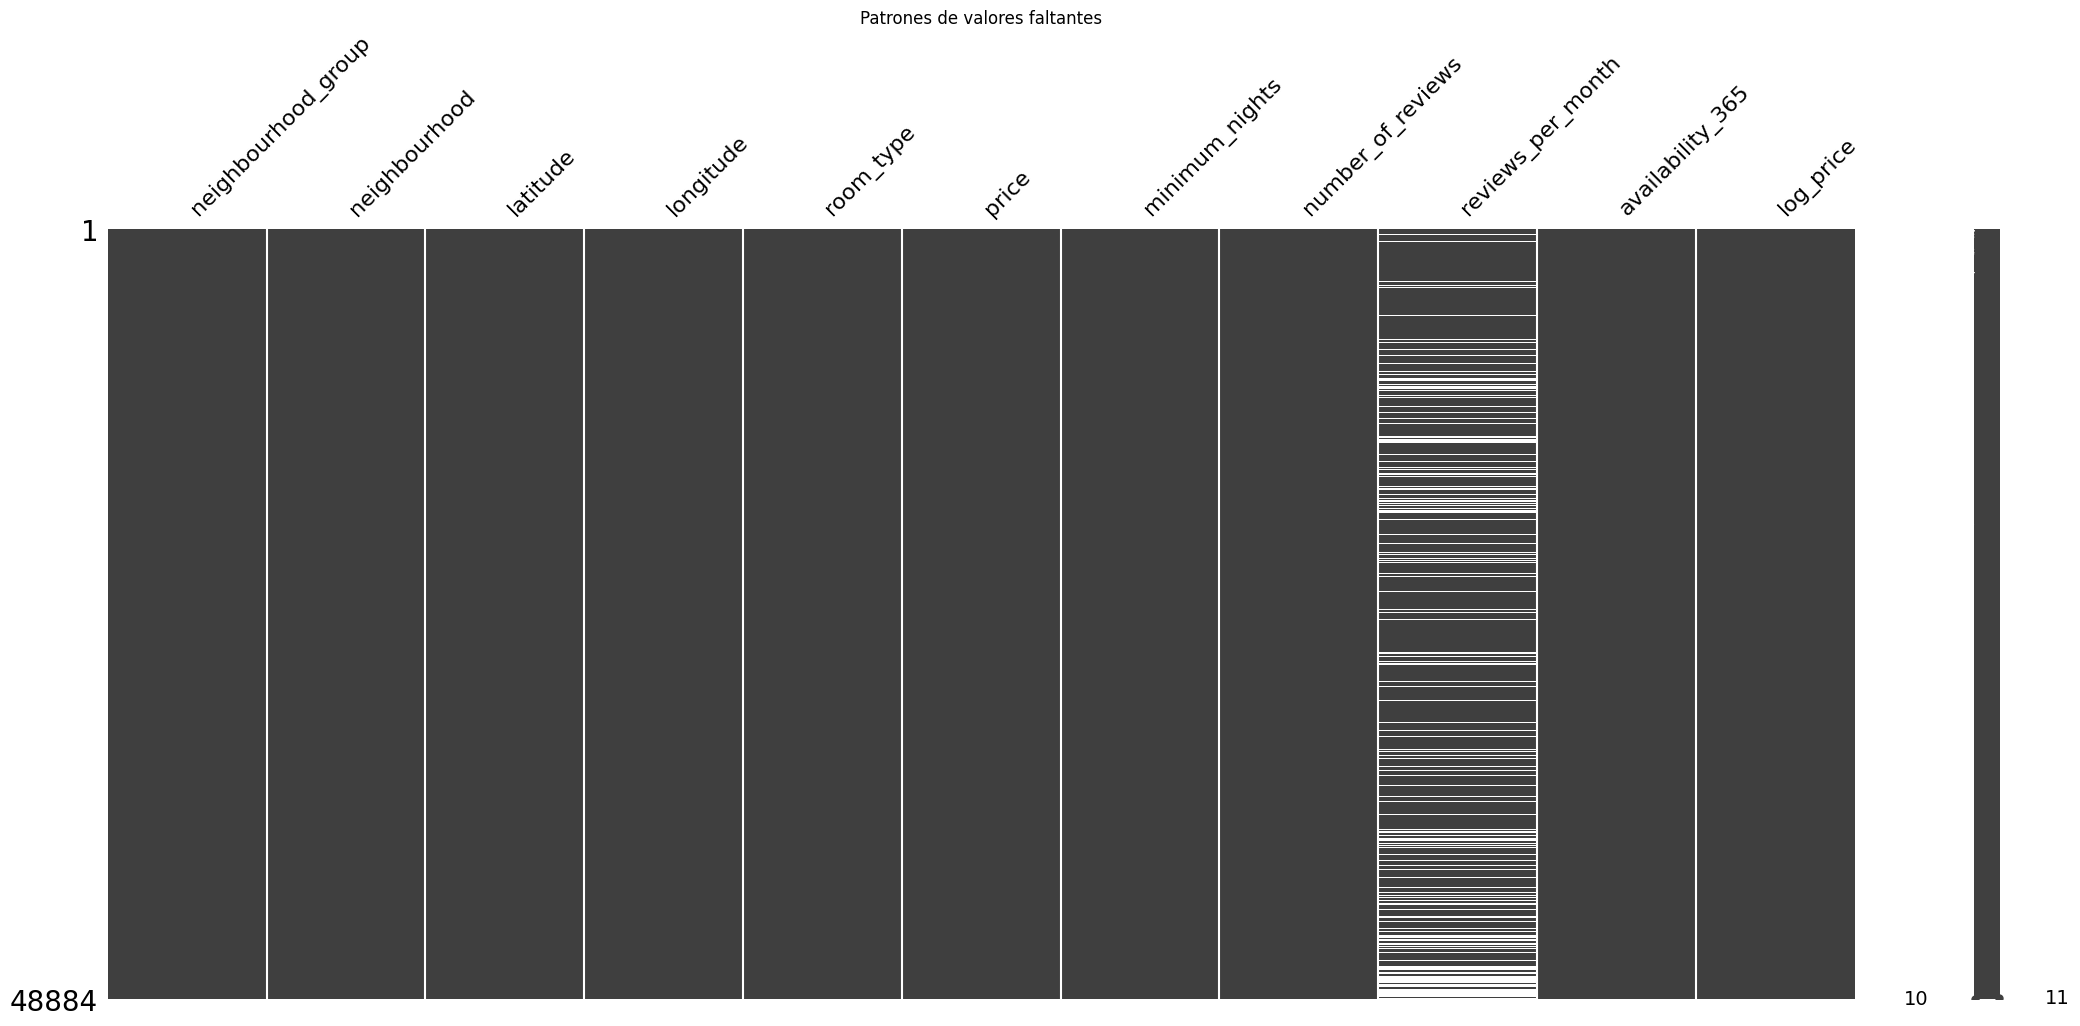

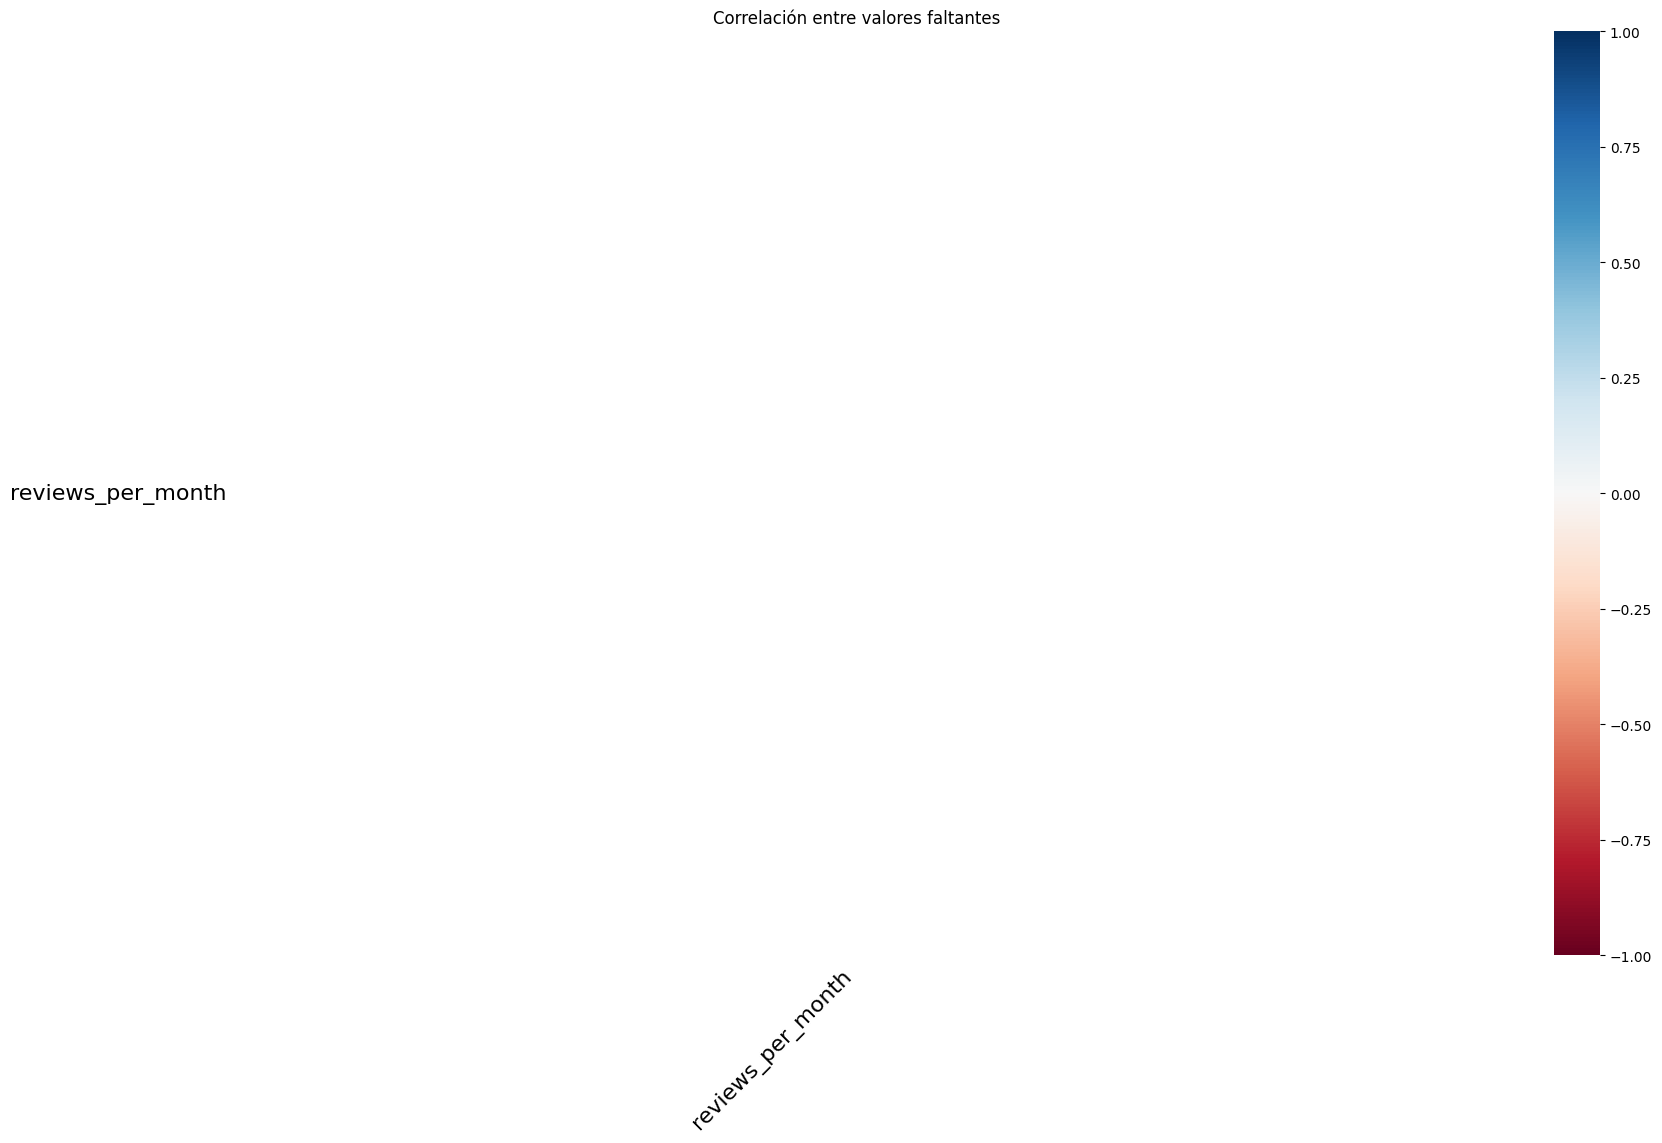

In [17]:
# Mapa de valores faltantes
msno.matrix(df)  # Visualización de valores nulos
plt.title("Patrones de valores faltantes")
plt.show()

# Mapa de correlaciones entre valores faltantes
msno.heatmap(df)  # Relación entre valores nulos
plt.title("Correlación entre valores faltantes")
plt.show()

Únicamente vemos datos faltantes en la columna reviews_per_month. Como solo existe una columna con valores faltante, no se pueden identificar patrones entre las variables con valores faltantes.

Imputación de valores faltantes. Existen distintos métodos pero en este caso vamos a apicar la imputación con la media.

In [18]:
# Identificar columnas numéricas con valores faltantes
num_cols_with_nan = df.select_dtypes(include=['number']).columns[df.select_dtypes(include=['number']).isnull().sum() > 0]

# Aplicar imputación con la media en esas columnas
df[num_cols_with_nan] = df[num_cols_with_nan].apply(lambda col: col.fillna(col.mean()))

# Confirmar que los valores faltantes fueron imputados correctamente
print(df[num_cols_with_nan].isnull().sum())

reviews_per_month    0
dtype: int64


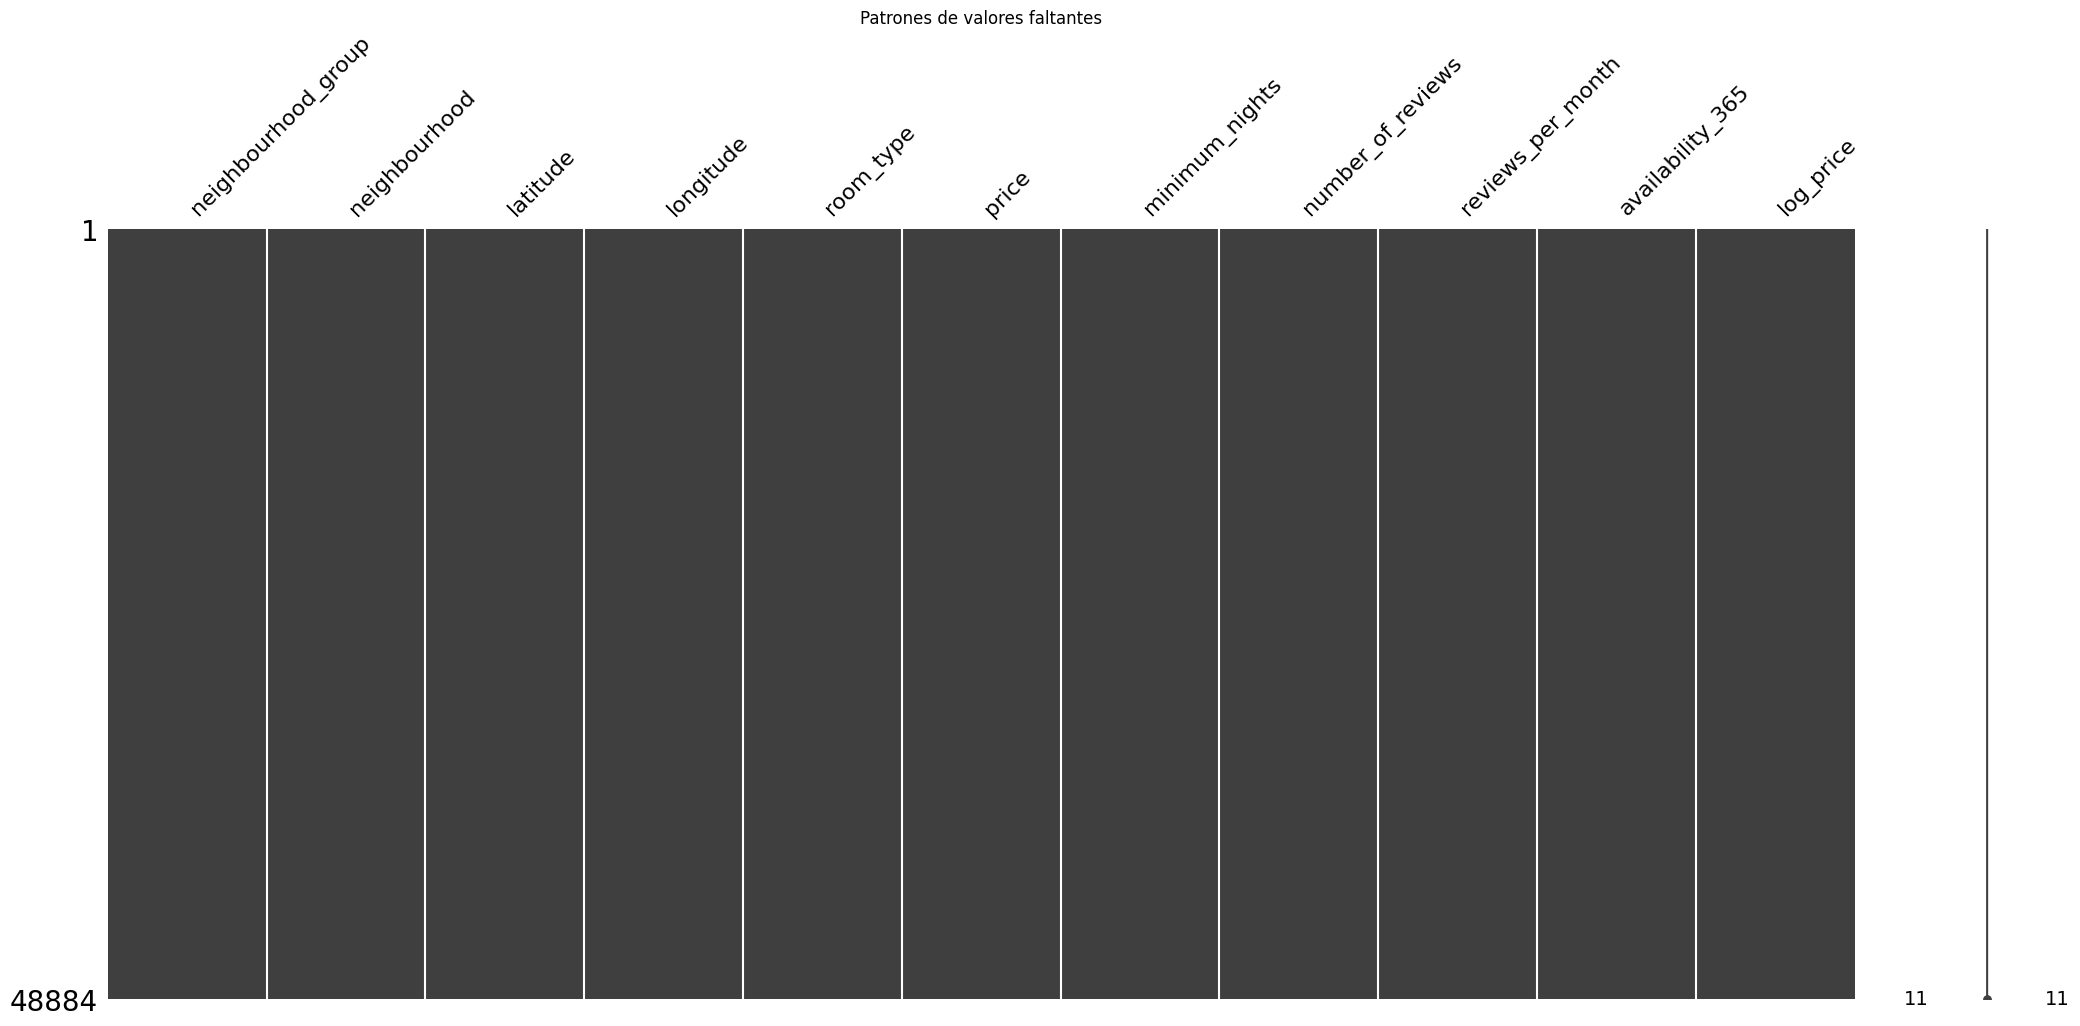

In [19]:
# Comprobamos que no existen valores faltantes
msno.matrix(df)  # Visualización de valores nulos
plt.title("Patrones de valores faltantes")
plt.show()

# Partición del dataset en conjunto de entrenamiento y test

In [20]:
# Definir X (variables predictoras) e Y (variable objetivo)
X = df.drop(['log_price','price'],axis=1) # Elimina 'price' porque es lo que queremos predecir
y = df['log_price']

#Dividimos el conjunto de datos en entrenamiento (80%) y prueba (20%), asegurando que la partición sea aleatoria pero reproducible:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Aplicamos la partición del dataset. Así, el conjunto de datos de entrenamiento representará el 80% del conjunto y el de prueba un 20%.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Con random_state conseguimos que que la partición sea siempre la misma

In [22]:
# Validar la distribución de datos
print(f'Tamaño del conjunto de entrenamiento: {X_train.shape}')
print(f'Tamaño del conjunto de prueba: {X_test.shape}')

Tamaño del conjunto de entrenamiento: (39107, 9)
Tamaño del conjunto de prueba: (9777, 9)


# Visualización de distribución de precios

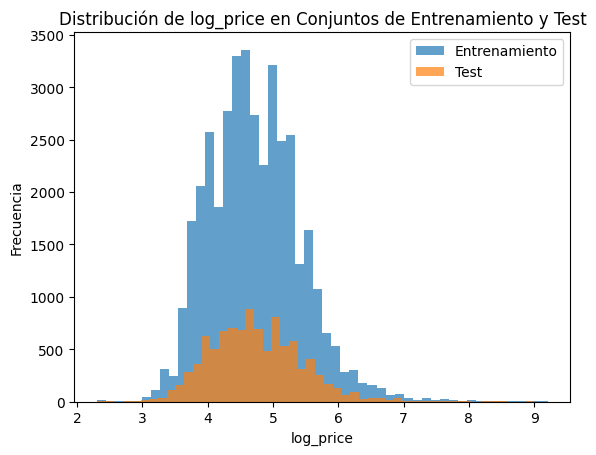

In [23]:
# Creamos un histograma para comprobar si la distribución de los precios en el conjunto de prueba es similar al de entrenamiento
plt.hist(y_train, bins=50, alpha=0.7, label='Entrenamiento', color='#1f77b4')
plt.hist(y_test, bins=50, alpha=0.7, label='Test', color='#ff7f0e')
plt.legend()
plt.xlabel('log_price')
plt.ylabel('Frecuencia')
plt.title('Distribución de log_price en Conjuntos de Entrenamiento y Test')
plt.show()

Observaciones influyentes

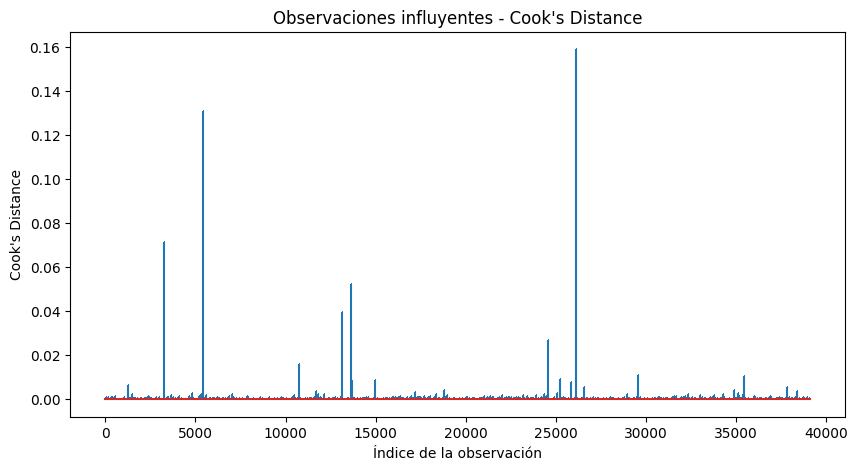

In [24]:
# Crear copia de X_train para evitar cambios no deseados
X_train_encoded = X_train.copy()

# Convertir solo columnas categóricas a números con LabelEncoder
for col in X_train_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train_encoded[col])

# Agregar constante para la regresión
X_train_const = sm.add_constant(X_train_encoded)

# Ajustar modelo de regresión lineal
model = sm.OLS(y_train, X_train_const).fit()

# Obtener Cook's Distance
influence = model.get_influence()
cooks_d, _ = influence.cooks_distance

# Visualización de Cook's Distance
plt.figure(figsize=(10, 5))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.xlabel("Índice de la observación")
plt.ylabel("Cook's Distance")
plt.title("Observaciones influyentes - Cook's Distance")
plt.show()

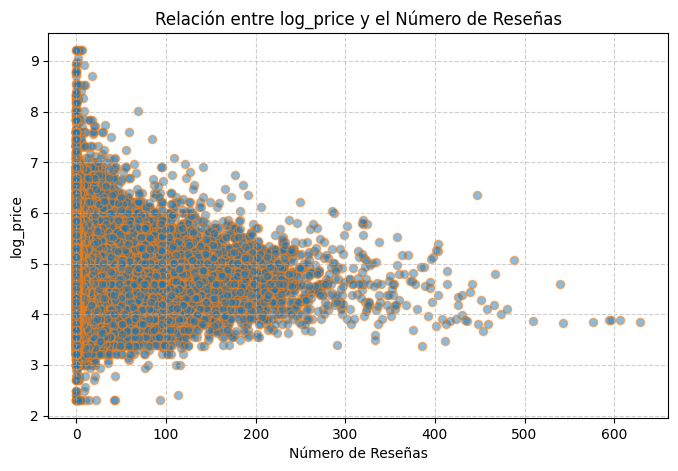

In [25]:
# Crear scatter plot de LOG_PRICE vs. number_of_reviews
plt.figure(figsize=(8, 5))
plt.scatter(df['number_of_reviews'], df['log_price'], alpha=0.5, color='#1f77b4', edgecolors='#ff7f0e')
plt.xlabel("Número de Reseñas")
plt.ylabel("log_price")
plt.title("Relación entre log_price y el Número de Reseñas")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

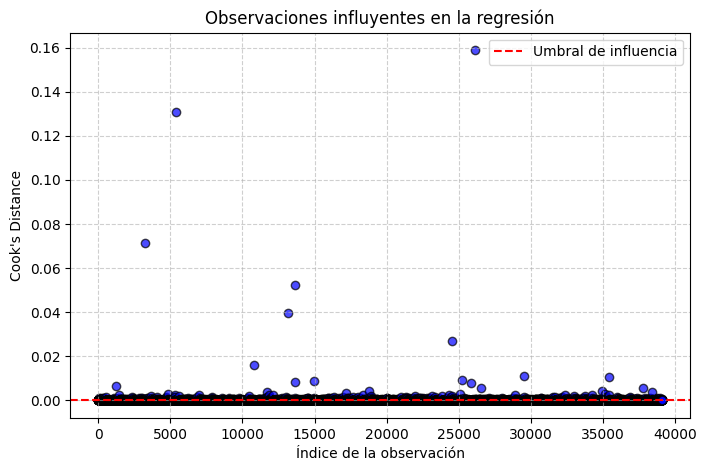

Observaciones influyentes detectadas: 1803


In [26]:
#Selección de variables predictoras y objetivo
X = df.drop(columns=['log_price', 'price'])  # Eliminamos la variable objetivo
y = df['log_price']

#Transformar variables categóricas a numéricas usando LabelEncoder
categorical_cols = ['neighbourhood_group', 'neighbourhood', 'room_type']
df_encoded = X.copy()

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))  # Convertimos a string antes de codificar

#Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size=0.2, random_state=42)

#Agregar constante a X_train para la regresión
X_train_const = sm.add_constant(X_train)

#Ajustar el modelo de regresión lineal
model = sm.OLS(y_train, X_train_const).fit()

#Obtener Cook's Distance para detectar observaciones influyentes
influence = model.get_influence()
cooks_d, _ = influence.cooks_distance

#Definir punto de corte basado en el tamaño del conjunto de entrenamiento
pto_corte = 4 / len(X_train)
observaciones_influyentes = np.where(cooks_d > pto_corte)[0]  # Índices de valores influyentes

#Visualización de Cook's Distance
plt.figure(figsize=(8, 5))
plt.scatter(np.arange(len(cooks_d)), cooks_d, alpha=0.7, color="blue", edgecolors="black")
plt.axhline(y=pto_corte, color='red', linestyle='--', label="Umbral de influencia")
plt.xlabel("Índice de la observación")
plt.ylabel("Cook's Distance")
plt.title("Observaciones influyentes en la regresión")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

#Mostrar cantidad de observaciones influyentes detectadas
print(f"Observaciones influyentes detectadas: {len(observaciones_influyentes)}")

In [27]:
# Obtener los índices de viviendas influyentes
idx_viviendas_influyentes = np.where(cooks_d > pto_corte)[0]

# Calcular el porcentaje de viviendas afectadas
porcentaje_viviendas_influyentes = (len(idx_viviendas_influyentes) / len(df)) * 100

# Mostrar el resultado
print(f'Porcentaje de viviendas a desestimar: {porcentaje_viviendas_influyentes:.2f}%')

Porcentaje de viviendas a desestimar: 3.69%


Creamos un nuevo conjunto de entrenamiento eliminando aquellos alojamientos con mayor impacto

In [28]:
X_train.index[idx_viviendas_influyentes]

Index([41245, 40299, 40469, 16596, 21523, 19713, 32041, 32913, 27422, 46104,
       ...
       25947, 46710, 43596, 22299, 23420,  5258,  2027, 40785, 11394,  1899],
      dtype='int64', length=1803)

In [29]:
X_train1 = X_train.loc[~X_train.index.isin(X_train.index[idx_viviendas_influyentes]),:]
X_test1 = X_test.loc[~X_test.index.isin(idx_viviendas_influyentes), :]

In [30]:
y_train1 = y_train.loc[~X_train.index.isin(X_train.index[idx_viviendas_influyentes])]
y_test1 = y_test.loc[~X_test.index.isin(idx_viviendas_influyentes)]

In [31]:
print(f'Total de viviendas eliminadas: {len(idx_viviendas_influyentes)}')
print(f'Tamaño original: {X_train.shape[0]}, Tamaño filtrado: {X_train1.shape[0]}')

Total de viviendas eliminadas: 1803
Tamaño original: 39107, Tamaño filtrado: 37304


# Extracción de características

A partir de las características originales obtener más datos, por ejemplo una columna que indique si era festivo/fin de semana en una daterminada fecha

In [32]:
# Entrenar un modelo XGBoot para evaluar la importancia de características
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42).fit(X_train1, y_train1)

# Creamos un df de importancias de características
dict_data = {'Feature':X_train1.columns, 'Importancia':xgb_model.feature_importances_*100}
df_imp = pd.DataFrame(dict_data)

# Ordenar descendentemente por importancia
df_imp.sort_values(by='Importancia', ascending=False, inplace=True)

In [33]:
# Nombres de columnas con una importancia mayor igual a un 1%
df_imp[df_imp['Importancia']>=1]

,Feature,Importancia
4,room_type,89.488449
3,longitude,3.125028
2,latitude,1.742294
5,minimum_nights,1.352103
8,availability_365,1.226531


In [34]:
#Filtrar solo las características con importancia >= 1%
features_seleccionadas = df_imp[df_imp['Importancia'] >= 1]['Feature'].tolist()

#Crear nuevo conjunto de datos con solo las características importantes
X_train1_filtrado = X_train1[features_seleccionadas]
X_test1_filtrado = X_test1[features_seleccionadas]  # Si tienes conjunto de prueba

print(f"Número de características eliminadas: {X_train.shape[1] - X_train1_filtrado.shape[1]}")
print(f"Número de características finales: {X_train1_filtrado.shape[1]}")

Número de características eliminadas: 4
Número de características finales: 5


In [35]:
#Calcular la matriz de correlación
matriz_corr = X_train1.corr()

#Calcular el VIF para cada variable en X_train1
vif = pd.Series([variance_inflation_factor(matriz_corr.values, i) 
                 for i in range(matriz_corr.shape[1])], 
                index=X_train1.columns)

# Mostrar los resultados
print(vif)

neighbourhood_group    2.113069
neighbourhood          1.395344
latitude               2.212493
longitude              1.529068
room_type              1.264951
minimum_nights         1.433363
number_of_reviews      3.529349
reviews_per_month      3.665755
availability_365       1.540058
dtype: float64


<Axes: >

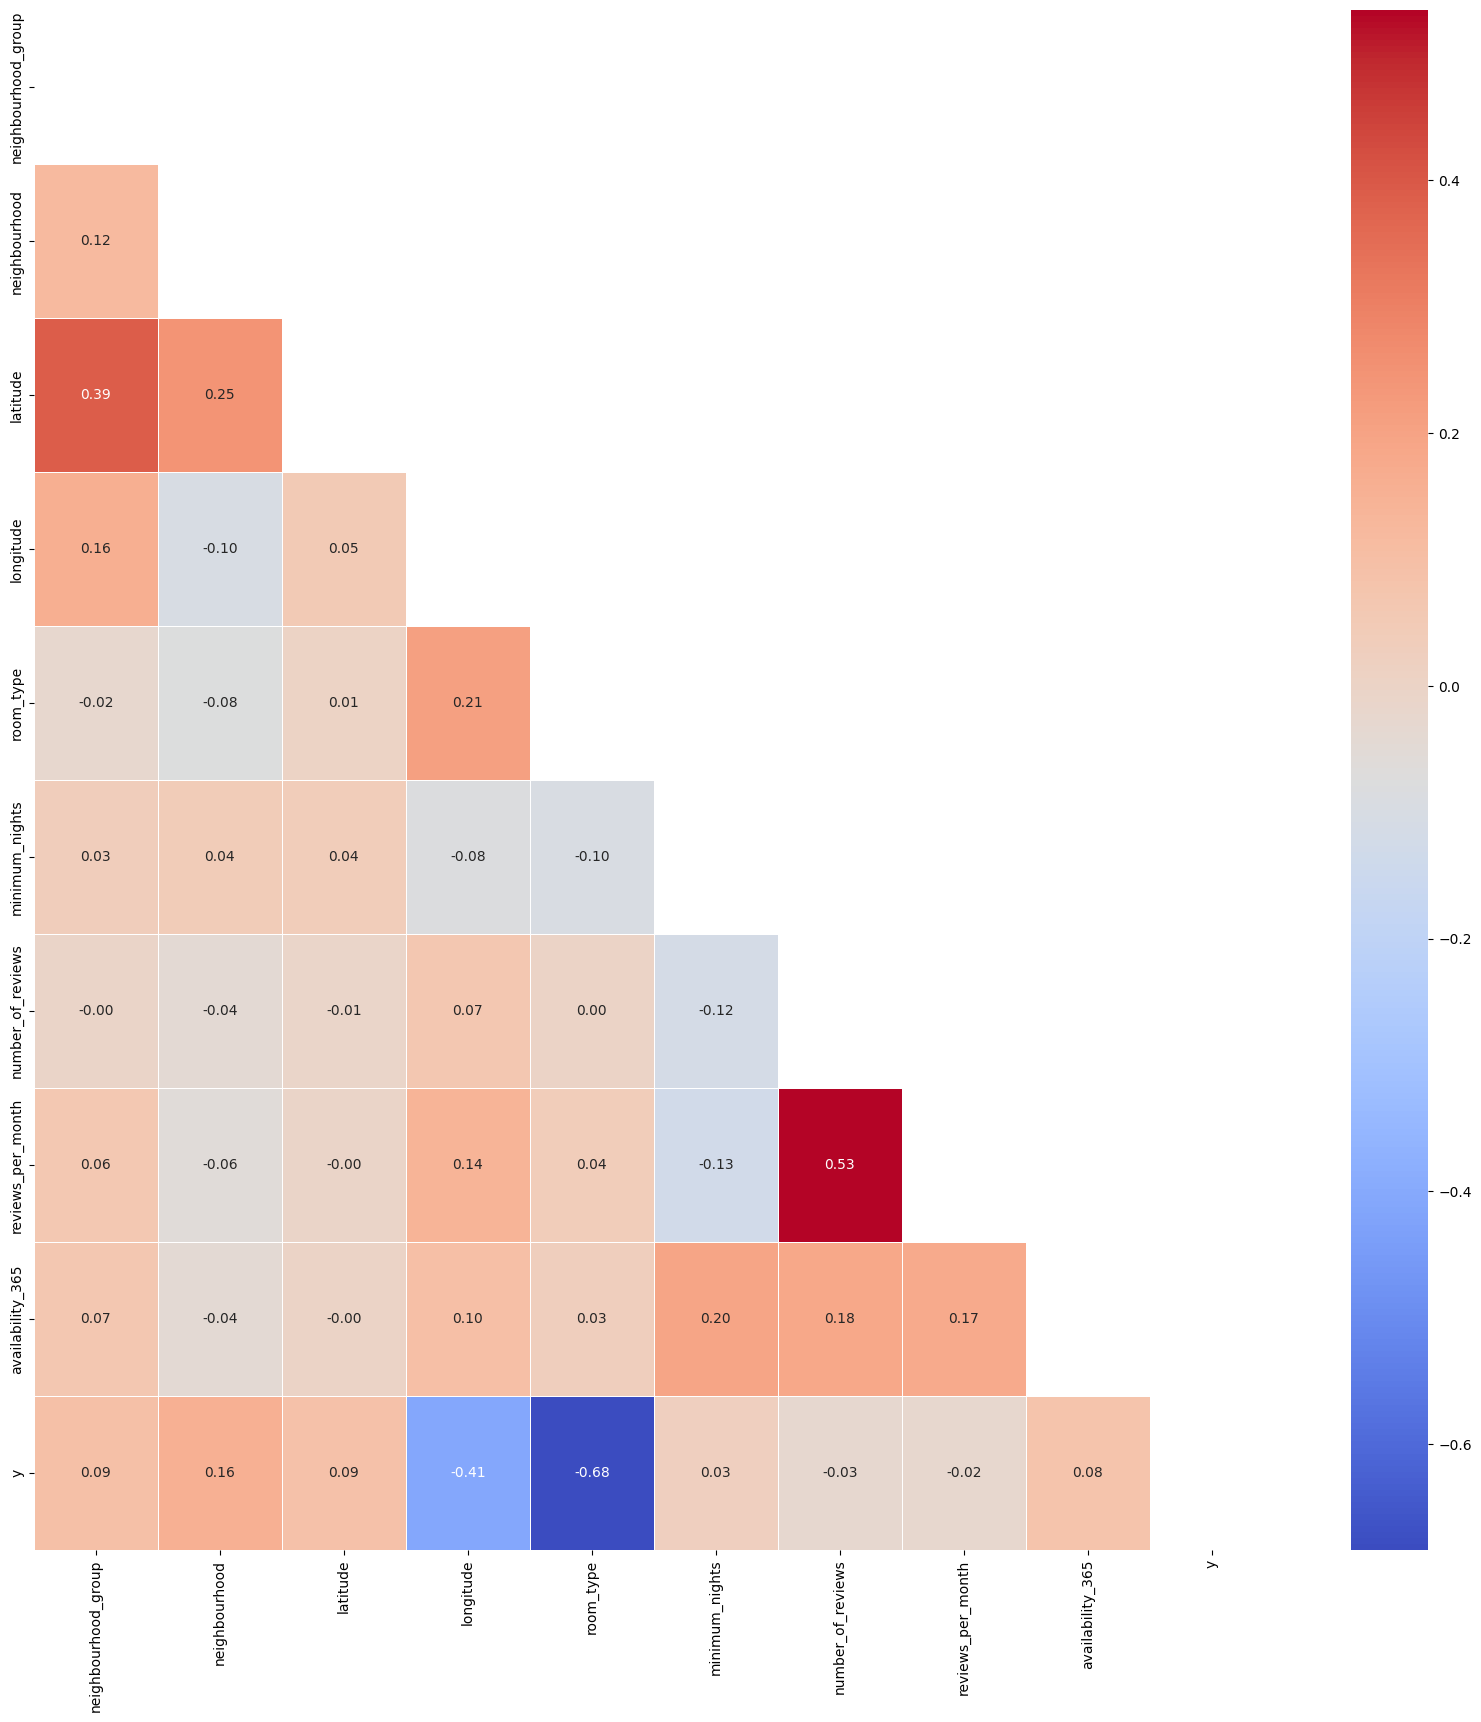

In [37]:
X_corr = X_train1.copy() #Copiamos X_train1 en X_corr. Así evitamos modificar el dataset original
X_corr['y'] = y_train1
corr = X_corr.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20,20))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

In [39]:
def calcular_vif(df):
    return pd.Series([variance_inflation_factor(df.values, i) for i in range(df.shape[1])], index=df.columns)

# Eliminar iterativamente variables con VIF > 5
X_train_final = X_train1_filtrado.copy()
X_test_final = X_test1_filtrado.copy()

while calcular_vif(X_train_final).max() > 5:
    var_a_eliminar = calcular_vif(X_train_final).idxmax()
    X_train_final.drop(columns=[var_a_eliminar], inplace=True)
    X_test_final.drop(columns=[var_a_eliminar], inplace=True)

# Mostrar nuevo listado de VIF después de la limpieza
print("Nuevo VIF después de la limpieza:")
print(calcular_vif(X_train_final))

Nuevo VIF después de la limpieza:
room_type           1.876928
longitude           2.706989
minimum_nights      1.307690
availability_365    1.783099
dtype: float64


# Escalado de las características

In [42]:
# Inicializar los escaladores
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Aplicar MinMaxScaler (normalización 0-1)
X_train_minmax = minmax_scaler.fit_transform(X_train_final)
X_test_minmax = minmax_scaler.transform(X_test_final)

# Aplicar StandardScaler (media 0, desviación estándar 1)
X_train_standard = standard_scaler.fit_transform(X_train_final)
X_test_standard = standard_scaler.transform(X_test_final)

# Verificar tamaños
print(f"X_train_minmax: {X_train_minmax.shape}, X_train_standard: {X_train_standard.shape}")
print(f"X_test_minmax: {X_test_minmax.shape}, X_test_standard: {X_test_standard.shape}")

X_train_minmax: (37304, 4), X_train_standard: (37304, 4)
X_test_minmax: (9441, 4), X_test_standard: (9441, 4)


In [43]:
# Inicializar el escalador
scaler = MinMaxScaler()

# Aplicar la transformación y conservar nombres e índices
X_train_sc = pd.DataFrame(scaler.fit_transform(X_train_final), columns=X_train_final.columns, index=X_train_final.index)
X_test_sc = pd.DataFrame(scaler.transform(X_test_final), columns=X_test_final.columns, index=X_test_final.index)
X_test_sc

,room_type,longitude,minimum_nights,availability_365
41320,0.5,0.369367,0.022044,0.079452
22079,0.5,0.481617,0.002004,0.649315
18778,0.0,0.487737,0.058116,0.265753
25494,0.5,0.491704,0.000000,0.000000
44319,0.5,0.492701,0.006012,1.000000
...,...,...,...,...
24329,0.5,0.371679,0.012024,0.175342
40905,0.5,0.531190,0.002004,0.000000
31179,0.0,0.454688,0.006012,0.213699
40872,0.5,0.581716,0.002004,0.942466
